# Case 3
## Patient Drug Review
### Otto Åström & Vili Niemi
### 14.3.2019

In this assignment we study if we can predict drug ratings based on their reviews. The reviews are from Drugs.com, and we'll be using the KUC Hackathon Winter 2018 dataset, as it is already split into training and test sets.

#### Preparing
First we load the data and create labels based on the "rating" variable. We have it set so that ratings ranging from 1-4 are considered "bad", 5-6 "neutral" and 7-10 "good". 

In [40]:
import pandas as pd

data = pd.read_csv("./drugsComTrain_raw.csv")

r = data['rating']
labels = -1*(r <= 4) + 1*(r >= 7)
# Add the label column to the data
data['label'] = labels

,uniqueID,drugName,condition,review,rating,date,usefulCount,label
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,1
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,1
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,0
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,1
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,1


Next we tokenize and pad the text in the "review" variable of our dataset. This means that we first break the text into words, phrases, symbols, or other meaningful elements called tokens, and then we pad all the sequences into the same length so we could analyse it easier.

In [14]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Read a part of the reviews and create training sequences (x_train)
samples = data['review'].iloc[:10000]
tokenizer = Tokenizer(num_words = 1000)
tokenizer.fit_on_texts(samples)
sequences = tokenizer.texts_to_sequences(samples)
x_train = pad_sequences(sequences, maxlen = 500)

Using TensorFlow backend.


In [16]:
from keras.utils import to_categorical

# Convert the labels to one_hot_category values
one_hot_labels = to_categorical(labels[:10000], num_classes = 3)

Helper functions like the ones below are helpful when you need to print something similar multiple times, or when you don't want to clog your code at some later point. Here we have made a function for making graphs that display the test and validation accuracy of a model, and a function for training a model. 

In [23]:
def plot_history(history):
    
    f, ax = plt.subplots(1, 2, figsize = (16, 7))
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.sca(ax[0])
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.sca(ax[1])
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
    
def train_model(model, x, y, e, bs, v, vs):
    h = model.fit(x, y, epochs = e, batch_size = bs, verbose = v, validation_split = vs)
    return h

Importing all we need for trying out various different models. You can comment out the ones you do not need, but we have chosen not to bother.

In [25]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from keras.layers import LSTM
from keras.layers import GRU
import matplotlib.pyplot as plt

#### The work
Actually making our neural network. Our model uses embedding and GRU without dropout.

In [35]:
model = Sequential()
model.add(Embedding(1000, 8, input_length = 500))
model.add(GRU(8, dropout = 0.2, recurrent_dropout = 0.2))
model.add(Dense(3, activation = 'softmax'))
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])

Training our model and printing out a graph showing its history. From this graph we visualize how accurate the model is and if it's doing any over- or underfitting based on how different the two lines are. If the training accuracy line is way higher than the validation accuracy, the model is overfitting, and vice versa with underfitting. 

Train on 7500 samples, validate on 2500 samples
Epoch 1/10
7500/7500 [==============================] - 140s 19ms/step - loss: 0.4693 - acc: 0.8251 - val_loss: 0.6516 - val_acc: 0.7520
Epoch 2/10
7500/7500 [==============================] - 134s 18ms/step - loss: 0.4661 - acc: 0.8291 - val_loss: 0.6620 - val_acc: 0.7552
Epoch 3/10
7500/7500 [==============================] - 146s 19ms/step - loss: 0.4688 - acc: 0.8231 - val_loss: 0.6583 - val_acc: 0.7536
Epoch 4/10
7500/7500 [==============================] - 148s 20ms/step - loss: 0.4673 - acc: 0.8251 - val_loss: 0.6621 - val_acc: 0.7460
Epoch 5/10
7500/7500 [==============================] - 143s 19ms/step - loss: 0.4602 - acc: 0.8315 - val_loss: 0.6676 - val_acc: 0.7524
Epoch 6/10
7500/7500 [==============================] - 146s 19ms/step - loss: 0.4664 - acc: 0.8276 - val_loss: 0.6697 - val_acc: 0.7524
Epoch 7/10
7500/7500 [==============================] - 143s 19ms/step - loss: 0.4642 - acc: 0.8268 - val_loss: 0.6711 - val_acc: 

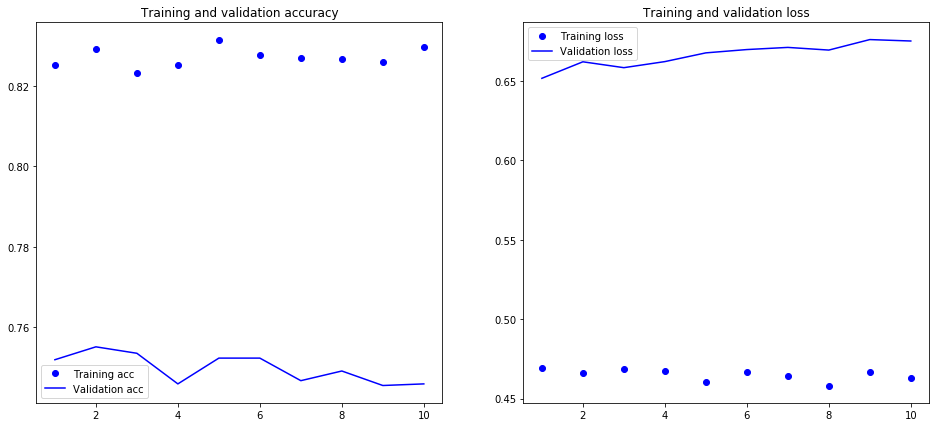

In [30]:
#(model, x, y, epochs, batch, verbose, validation split)
h = train_model(model, x_train, one_hot_labels, 13, 32, 1, 0.3)
plot_history(h)

#### Training results
Above we see the results from our training data. Small changes into our hyperparameters get us accuracy of around 70-75% witht the validation data, and around 75-80 with the training data with a maximum of 5% difference between the validation and training sets.

#### Testing
Then we'll try out our test set, to see how well our model actually works with some data it hasn't seen before. We start by repeating the process we did to our training data.

In [45]:
test = pd.read_csv("./drugsComTest_raw.csv")
test['label'] = labels
samples2 = test['review'].iloc[:10000]
tokenizer.fit_on_texts(samples2)
sequences2 = tokenizer.texts_to_sequences(samples2)
X_test = pad_sequences(sequences2, maxlen = 500)
# Convert the labels to one_hot_category values
one_hot_labels = to_categorical(labels[:10000], num_classes = 3)

Then we fit that data into our premade model and attempt making a prediction. If our model achieves similar results with the test data as with the training and the validation data it means our model is working as intended.

In [51]:
from sklearn.metrics import confusion_matrix

pred = model.predict(X_test)

#print("Accuracy: {:.3f}".format(model.score(X_test, one_hot_labels)))
print("Confusion Matrix")
print(confusion_matrix(pred, one_hot_labels))

Confusion Matrix


ValueError: Classification metrics can't handle a mix of continuous-multioutput and multilabel-indicator targets